In [246]:
%matplotlib notebook
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [247]:
import numpy as np
import pandas as pd

In [248]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [249]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [250]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
engine
inspector=inspect(engine)

In [251]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [252]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [253]:
# check the table content
engine.execute('SELECT * FROM measurement limit 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [254]:
# to know what are columns & data type for 'measurement' table
meas_table=inspector.get_columns('measurement')
for column in meas_table:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [255]:
engine.execute('SELECT * FROM station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [256]:
# to know what are columns & data type for 'station' table
station_table=inspector.get_columns('station')
for column in station_table:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [257]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [258]:
# Create our session (link) from Python to the DB
session = Session(engine)
session

# Exploratory Climate Analysis

In [259]:
# get the latest date in the measurement table
# --> this will be use in considering the last 12 months of data
latest_date = engine.execute('SELECT max(date) FROM measurement').fetchall()[0][0]
print(latest_date)

2017-08-23


In [260]:
# setup dates of trip
query_date= dt.date(2018, 3, 1) + dt.timedelta(days=14)
print("start date: ", dt.date(2018,3,1)," "," Finish date: ", query_date)

start date:  2018-03-01    Finish date:  2018-03-15


In [261]:
# Design a query to retrieve the last 12 months of precipitation data
year_ago=dt.date(2017,8,23) - dt.timedelta(days=365)
year_ago_prp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).\
order_by(Measurement.date).statement
print(year_ago)
print(year_ago_prp)

2016-08-23
SELECT measurement.date, measurement.prcp 
FROM measurement 
WHERE measurement.date >= :date_1 ORDER BY measurement.date


In [263]:
# Store query results as a Pandas Dataframe and set the index to the date column
df=pd.read_sql(year_ago_prp,engine).dropna()
df = df.rename(columns = {'prcp': 'precipitation'})
df.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
4,2016-08-23,0.02
5,2016-08-23,1.79


<IPython.core.display.Javascript object>


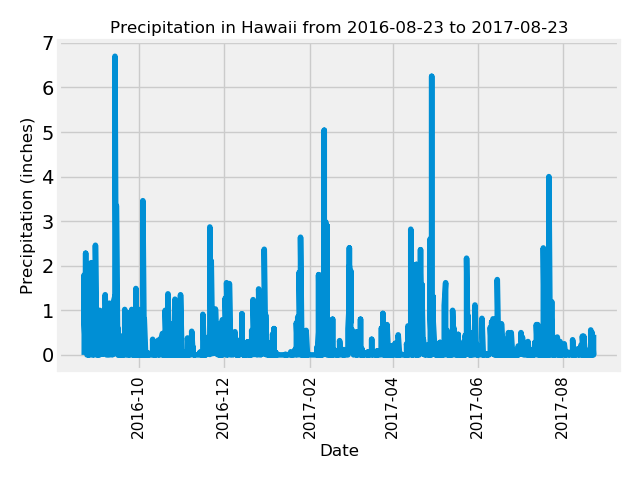

In [264]:
# plot precipitation data
df['date'] = pd.to_datetime(df['date'])
#df
plt.plot(df['date'], df['precipitation'])
plt.title("Precipitation in Hawaii from 2016-08-23 to 2017-08-23", size ='12')
plt.xlabel('Date', size = '12')
plt.ylabel('Precipitation (inches)', size = '12')
plt.xticks(rotation='90', size = '11')
plt.tight_layout()
plt.show()


In [265]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station analysis

In [266]:
# how many stations are available in the dataset
# first to check if both tables (measurement & station) give the same # of station
station_com = session.query(Measurement.station).distinct().count() == session.query(Station.station).distinct().count()
# then print out the result
if station_com:
    station_num = session.query(Measurement.station).distinct().count()
    print(f'The number of station available are: {station_num}')
else:
    print('the tables are not sync')


The number of station available are: 9


In [267]:
# What are the most active stations?
# List the stations and the counts in descending order.
station_describe = session.query(Measurement.station, func.count(Measurement.id)) \
                    .group_by(Measurement.station)\
                    .order_by(func.count(Measurement.id).desc())
station_describe.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [268]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = station_describe.first()[0]
query_temp = session.query(func.min(Measurement.tobs),
                          func.max(Measurement.tobs),
                          func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station)
query_temp.all()

[(54.0, 85.0, 71.66378066378067)]

In [269]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
# Station ID with highest observed
station_id = station_describe[0][0]
print(station_id)
station_name = session.query(Station.name).filter(Station.station==station_id).all()
station_name

USC00519281


[('WAIHEE 837.5, HI US')]

<IPython.core.display.Javascript object>


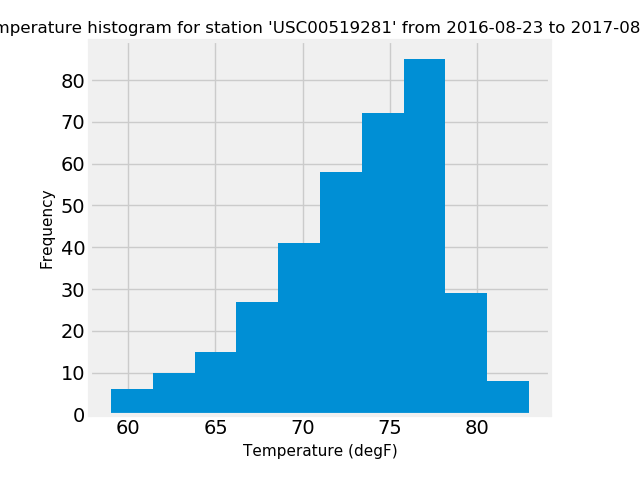

In [290]:
# Query the last 12 months of temperature observation data for above station
# and plot the results above as a histogram
temperature_query = session.query(Measurement.tobs)\
                    .filter(Measurement.date > year_ago)\
                    .filter(Measurement.station == station_id).all()
#temperature_query
temperature_query = [o[0] for o in temperature_query]
# histogram plot
plt.figure()
plt.title("Temperature histogram for station 'USC00519281' from 2016-08-23 to 2017-08-23" , size='12')
plt.hist(temperature_query)
plt.ylabel("Frequency", size = '11')
plt.xlabel('Temperature (degF)', size ='11')
plt.tight_layout()

# Temperature Analysis (optional)

In [281]:
def calc_temps(start_dt, end_dt):
    from datetime import datetime
    
    dt1 = datetime.strptime(start_dt, '%Y-%m-%d')
    dt2 = datetime.strptime(end_dt, '%Y-%m-%d')
    
    data = session.query(Measurement.tobs).\
        filter(Measurement.date >= dt1).\
        filter(Measurement.date <= dt2).all()
        
    data = [x[0] for x in data]
    
    summary = pd.DataFrame({'min': min(data),
                            'max': max(data),
                            'mean': sum(data)/len(data)},index =[0])
    
    return summary

In [282]:
# setup dates of trip
query_date= dt.date(2018, 3, 1) + dt.timedelta(days=14)
print("start date: ", dt.date(2018,3,1)," "," Finish date: ", query_date)

start date:  2018-03-01    Finish date:  2018-03-15


In [283]:
# Matching date based on the setup date above
match_start_date = '2017-03-01'
match_end_date = '2017-03-15'

In [284]:
temp_df = calc_temps(match_start_date, match_end_date)
temp_df

,min,max,mean
0,62.0,82.0,71.282353


<IPython.core.display.Javascript object>


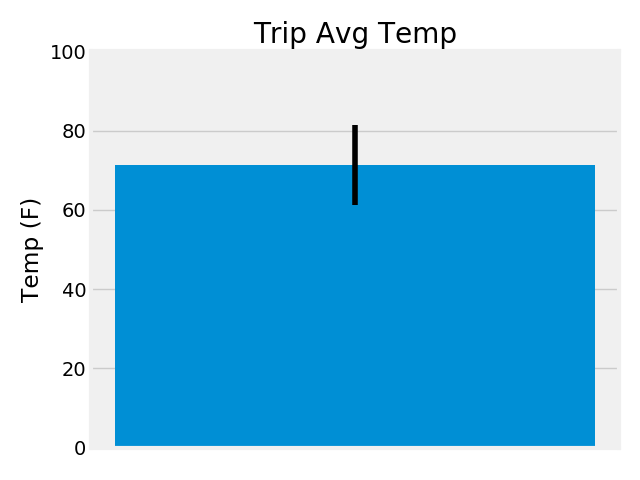

In [298]:
plt.figure()
yerr_line = (temp_df['max']-temp_df['min'])/2
plt.bar(0,temp_df["mean"], yerr = yerr_line)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.ylim([0,100])
plt.xticks([])
plt.tight_layout()